In [27]:
import skimage.io as io
import numpy as np
import csv
import datetime
import glob
import ipywidgets as widgets
from PIL import Image as im
import os
from matplotlib import pyplot as plt
import skimage.morphology as skmorph
import scipy.ndimage as ndi
from skimage import data
from skimage import filters
from skimage import feature
import skimage.measure as skmeas
import skimage.segmentation as skseg
from skimage.feature import peak_local_max
import random
import pandas as pd
import cv2
import copy

# Global variables
if os.name == "nt":
    FILE_SEP = "\\"
else:
    FILE_SEP = "/"

In [28]:
# Global variables
file_locations_340 = []
file_locations_ratio = []
file_names = []
image_fps = 10
s = {'description_width':'initial'} # A default widget style

# Aggregating 340 and Ratio Tifs into Lists
for image in sorted([f.split(FILE_SEP)[-1] for f in glob.glob("../image_stacks/*", recursive=False)], key=str.casefold):
    file_names.append(str(image))
    file_locations_340.append("../image_stacks/" + image + "/" + image + " 340nm.tif")
    file_locations_ratio.append("../image_stacks/" + image + "/" + image + " Ratio.tif")
fps_widget = widgets.BoundedIntText(value=image_fps, min=0, max=100, step=1,
                    description='FPS of tif files:', disabled=False, layout={'width':'150px'}, style=s)
def f(w1):
  global image_fps
  image_fps = fps_widget.value
display(widgets.interactive(f, w1 = fps_widget))

interactive(children=(BoundedIntText(value=10, description='FPS of tif files:', layout=Layout(width='150px'), …

In [29]:
# Create Appropriately Labeled Results Directories
if not os.path.exists("../results"):
  os.mkdir("../results")
resultsdirs = []
for image in sorted([f.split(FILE_SEP)[-1] for f in glob.glob("../image_stacks/*", recursive=False)], key=str.casefold):
    resultsdirs.append("../results/" + image + " Results")
    if not os.path.exists("../results/" + image + " Results"):
        os.mkdir("../results/" + image + " Results")
print("Done.") # Inform User that codeblock is done running

Done.


In [30]:
%matplotlib inline

baseline_imgs = []
# Reading in 340 tifs to make initial images for masking
for file in file_locations_340:
    image_340 = io.imread(file, plugin="tifffile")
    image_340 = image_340[0]
    baseline_img = cv2.normalize(image_340, None, alpha=0,beta=255,norm_type=cv2.NORM_MINMAX)
    baseline_img = cv2.GaussianBlur(baseline_img, (9,9), cv2.BORDER_DEFAULT)
    img = baseline_img.astype('uint8')
    baseline_imgs.append(img)

# Creating label and dropdown widgets
label_widgets = [widgets.Label("Threshold Size for " + file_names[i] + ":") for i in range(0,len(baseline_imgs))]
threshold_widgets = [widgets.Dropdown(options=[('XSmall',21),('Small',41),('Medium',71),('Large',141)],value=41) for i in range(0,len(baseline_imgs))]
out = widgets.Output()

# Displaying each baseline image and widget for selecting threshold size for that image
for i in range(0,len(baseline_imgs)):
    thresh_widg = widgets.VBox(children=[label_widgets[i],threshold_widgets[i]])
    threshold_options = widgets.HBox(children=[out,thresh_widg])
    display(threshold_options)
    with out:
        plt.figure(figsize=(5,5))
        plt.imshow(baseline_imgs[i])
        plt.show()
        plt.close() # Frees up memory
    out = widgets.Output()

In [31]:
# %matplotlib inline

# Initial Values for widgets
erosions = 0
max_size = 6000
min_size = 200
keep_edge_ROIS = True

s = {'description_width':'initial'} # A default widget style

# Creating erosions and other widgets
erosions_widgets = [widgets.BoundedIntText(value=erosions, min=0, max=10, step=1,
                    description='Number of erosions', disabled=False, layout={'width':'220px'}, style=s) 
                   for i in enumerate(baseline_imgs)]
max_size_widgets = [widgets.BoundedIntText(value=max_size, min=500, max=8000, step=50,
                    description='Max Size of ROIs', disabled=False, layout={'width':'220px'}, style=s)
                   for i in enumerate(baseline_imgs)]
min_size_widgets = [widgets.BoundedIntText(value=min_size, min=0, max=8000, step=50,
                    description='Min Size of ROIs', disabled=False, layout={'width':'220px'}, style=s)
                   for i in enumerate(baseline_imgs)]
keep_edge_ROIS_widgets = [widgets.Checkbox(value=keep_edge_ROIS, layout={'width':'300px'}, style = s, 
                                         description="Un-Check this box to discard edge ROIS",
                                         disabled=False, indent=False)
                         for i in enumerate(baseline_imgs)]
label_widgets = [widgets.Label("Mask for " + file_names[i]) for i in range(0,len(baseline_imgs))]

# Empty list for storing mask images
masks = []

# Thresholding each image based on selected threshold size to create list of masks
for i in range(0,len(baseline_imgs)):
    thresh = cv2.adaptiveThreshold(baseline_imgs[i],255,cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY,threshold_widgets[i].value,-1)
    mask = ndi.binary_fill_holes(skmorph.binary_dilation(filters.median(thresh)))
    masks.append(mask)

# Displaying each mask
out = widgets.Output()
for i in range(0,len(baseline_imgs)):
    widg = widgets.VBox(children=[label_widgets[i],erosions_widgets[i],max_size_widgets[i],
                                  min_size_widgets[i], keep_edge_ROIS_widgets[i]])
    mask_widgs = widgets.HBox(children=[out,widg])
    display(mask_widgs)
    with out:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = [10, 10])
        ax1.imshow(baseline_imgs[i])
        ax2.imshow(masks[i])
        plt.show()  
        plt.close() # Frees up memory
    out=widgets.Output()

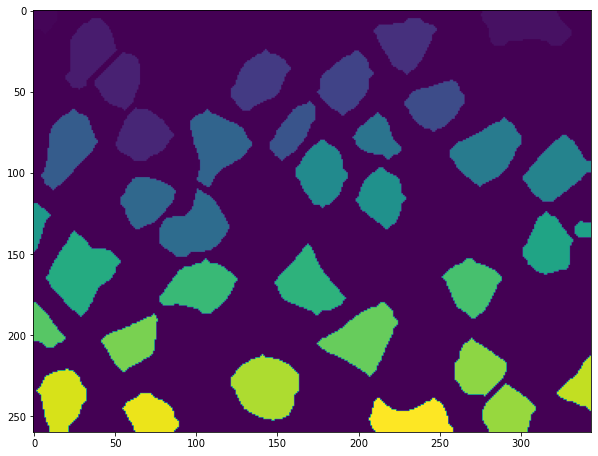

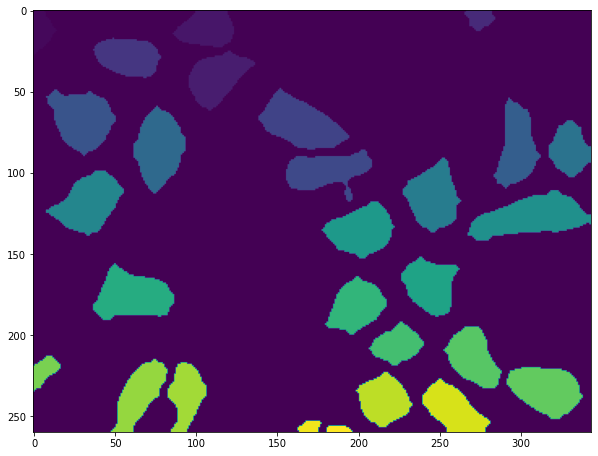

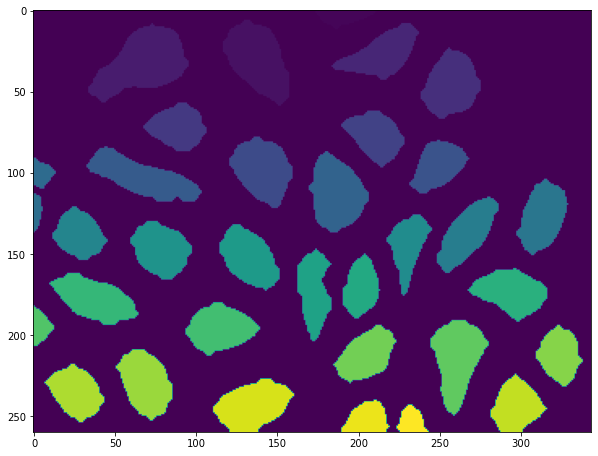

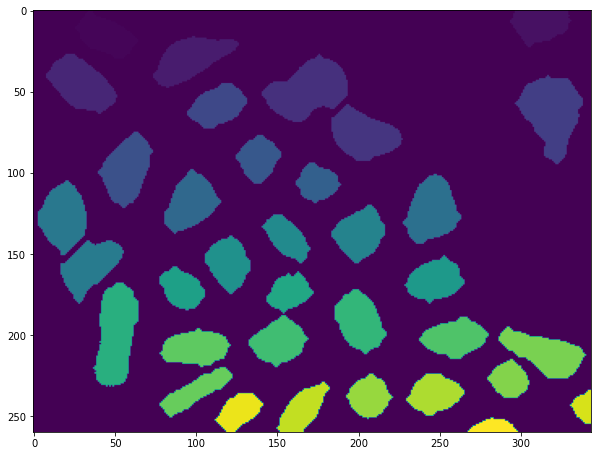

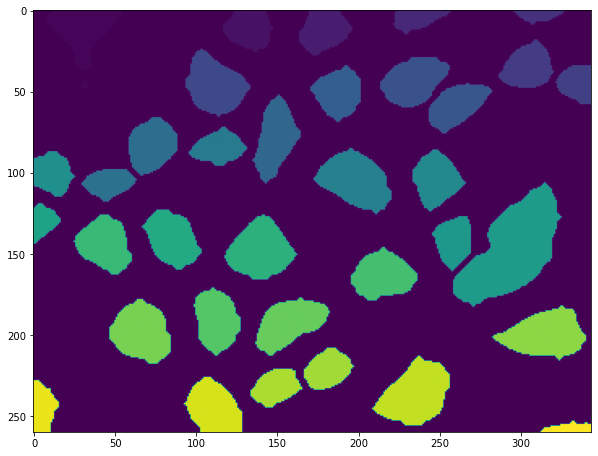

In [32]:
%matplotlib inline
# New bounding box segmentation method
segmented_masks = []

# Removing small objects
for i in range(0,len(baseline_imgs)):
    mask_label = skmeas.label(masks[i])
    objs = skmeas.regionprops(mask_label)
    temp = np.zeros_like(mask_label)
    for obj in objs:
        if obj.area < max_size_widgets[i].value and obj.area > min_size_widgets[i].value:
            temp = temp + (mask_label == obj.label)
    
    masks[i] = temp.astype('int32')
    
# Performing Erosions
for i in range(0,len(baseline_imgs)):
    for j in range(erosions_widgets[i].value):
        masks[i] = skmorph.binary_erosion(masks[i])
    
# Obtaining bounding boxes for each object in mask
for i in range(0,len(baseline_imgs)):
    mask_label = skmeas.label(masks[i])
    objs = skmeas.regionprops(mask_label)
    labeled_mask = np.zeros(masks[i].shape)
    increment = 0
    for obj in objs:
        box = obj.bbox
        # Removing any other objects from bounding box
        temp = np.zeros(masks[i].shape)
        temp_label = skmeas.label(masks[i])
        temp_objs = skmeas.regionprops(temp_label)
        for temp_obj in temp_objs:
            if temp_obj == obj:
                temp = temp + (temp_label == temp_obj.label)
        temp = temp.astype('int32')
        image = temp[box[0]:box[2],box[1]:box[3]]
        # Taking distance transform of bounding box
        dist = ndi.distance_transform_edt(image)
        # Normalizing distance transform to [0,1]
        dist_norm = cv2.normalize(-dist, None, alpha=0,beta=1,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
        dist_norm = cv2.GaussianBlur(dist_norm, (3,3), cv2.BORDER_DEFAULT)
        # Taking bounding box area from original intensity image
        intense = (baseline_imgs[i][box[0]:box[2],box[1]:box[3]])
        # Normalizing intensity image to [0,1]
        intense_norm = cv2.normalize(intense, None, alpha=0,beta=1,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
        intense_norm = cv2.GaussianBlur(intense_norm, (3,3), cv2.BORDER_DEFAULT)
        # Subtracting distance transform values from intensity values
        S = intense_norm - dist_norm
        h_max = skmorph.extrema.h_maxima(S,.15)
        coords = peak_local_max(h_max,min_distance = 10, exclude_border=False, 
                                footprint=np.ones((4,4)),labels=image)
        mask = np.zeros(S.shape,dtype=bool)
        mask[tuple(coords.T)] = True
        markers = ndi.label(mask)[0]
        labels = skseg.watershed(-S,markers,mask=image,watershed_line=True)
        watershed_lines = np.zeros(shape=np.shape(labels)) # Creating watershed lines mask
        watershed_lines[labels==0] = 1 #Filling in watershed lines mask
        watershed_lines = skmorph.binary_dilation(watershed_lines) # Dilating Watershed Lines
        watershed_lines = skmorph.binary_dilation(watershed_lines)
        labels[watershed_lines==1] = 0 # Applying dilated watershed lines to labels
        obj_indexes = labels > 0
        labels[obj_indexes] = labels[obj_indexes] + increment
        increment = np.max(labels) + 1
        labeled_mask[box[0]:box[2],box[1]:box[3]][obj_indexes] = labels[obj_indexes]
        #plt.figure(figsize=(10,10))
        #plt.imshow(labels)
        #plt.show()
        #plt.close()
    segmented_masks.append(labeled_mask)
    plt.figure(figsize=(10,10))
    plt.imshow(labeled_mask)
    plt.show()
    plt.close() # Frees up memory

In [33]:
%matplotlib inline

# Global Variables
ratio_imgs = []
final_imgs = []
Master_ROIs = []
Master_COUNTs = []
Master_Rs = []
# Reading in ratio tifs to make images for comparison with processed masks
for file in file_locations_ratio:
    image_ratio = io.imread(file, plugin="tifffile")
    ratio_img = image_ratio[0]
    img = ratio_img.astype('uint8')
    ratio_imgs.append(img)
    
# Processing each segmented mask
for i in range(0,len(baseline_imgs)):
    # Closing edges
    eroded_water = skmorph.binary_erosion(segmented_masks[i])
    eroded_water_2 = skmorph.binary_erosion(eroded_water)
    closed_one = skmorph.binary_closing(eroded_water_2)
    closed_two = skmorph.binary_closing(closed_one)
    # Canny edge detection
    edges= feature.canny(closed_two, sigma = 2).astype(int)
    dilated_edges = skmorph.binary_dilation(edges).astype(int)
    # Edge ROI sealing if keep ROIS is True
    if keep_edge_ROIS == True:
        count = 0
        while count < max_size:
            rand_x = random.randint(0,edges.shape[0]-1)
            rand_y = random.randint(0,edges.shape[0]-1)
            final = skseg.flood_fill(dilated_edges,(rand_x,rand_y), 5)
            count = np.count_nonzero(final == 5)
        final[final<2] = 255
    else:
        final = ndi.binary_fill_holes(dilated_edges)
    mask_label = skmeas.label(final)
    objs = skmeas.regionprops(mask_label)
    final = np.zeros_like(mask_label)
    for obj in objs:
        ratio_mean = 0
        for x_coord, y_coord in obj.coords:
            ratio_mean += ratio_imgs[i][x_coord,y_coord]
        ratio_mean = ratio_mean / len(obj.coords)
        if ratio_mean > 1 and obj.area < max_size_widgets[i].value and obj.area > min_size_widgets[i].value:
            final = final + (mask_label == obj.label)
    # Thresholding
    final = final.astype(np.uint8)
    ret, ratio_mask = cv2.threshold(ratio_imgs[i], 1, 255, cv2.THRESH_BINARY)
    ratio_mask = ratio_mask.astype(np.uint8)
    # BitwiseAND operation to only keep parts of ROIs that are present in both original mask and ratio_img mask
    final = cv2.bitwise_and(ratio_mask,final)
    # Filling in holes of ROIs
    final = ndi.binary_fill_holes(final)
    final = skmorph.binary_dilation(final)
    final = ndi.binary_fill_holes(final)
    
    mask_label = skmeas.label(final)
    objs = skmeas.regionprops(mask_label)
    final = np.zeros_like(mask_label)
    # Final removal of any accidental ROIs created
    for obj in objs:
        if obj.area < max_size_widgets[i].value and obj.area > min_size_widgets[i].value:
            final = final + (mask_label == obj.label)
    final_imgs.append(final)
    
    #For displaying updated masks
    #plt.figure(figsize=(5,5))
    #plt.imshow(final)
    #plt.show()
    #plt.close() # frees up memory

# Creating master lists of ROIS and counts for each final image
# Saved in case user wants to reset ROIs Removed
for i in range(0,len(baseline_imgs)):
    R, n = skmeas.label(final_imgs[i], return_num = True)
    ROI, COUNT = np.unique(R, return_counts = True)
    Master_ROIs.append(ROI)
    Master_COUNTs.append(COUNT)
    Master_Rs.append(R)
    
# Creating duplicate list of masks to use in ROI removal
Removal_Masks = copy.deepcopy(final_imgs)
print("Done.") # Inform User that codeblock is done running

Done.


In [34]:
Removal_ROIs = []
Removal_COUNTs = []
Removal_Rs = []
reset_mask = False
# Creating lists of ROIs and counts to be used in ROI removal
for i in range(0,len(baseline_imgs)):
    R, n = skmeas.label(Removal_Masks[i], return_num = True)
    ROI, COUNT = np.unique(R, return_counts = True)
    Removal_ROIs.append(ROI)
    Removal_COUNTs.append(COUNT)
    Removal_Rs.append(R)
    
# Creating widgets for ROI removal
reset_mask_widgets = [widgets.Checkbox(value=reset_mask, layout={'width':'300px'}, style = s, 
                                         description="Reset to original mask",
                                         disabled=False, indent=False)
                         for i in enumerate(baseline_imgs)]
removal_widgets = [widgets.SelectMultiple(options=Removal_ROIs[i][1:], description = 'ROIs for Removal',
                                         disabled=False, layout={'width':'175px', 'height':'120px'}, style={'description_width':'100px'})
                   for i in range(0,len(baseline_imgs))]
label_widgets = [widgets.Label("Mask for " + file_names[i]) for i in range(0,len(baseline_imgs))]


out = widgets.Output()
for i in range(0,len(baseline_imgs)):
    widg = widgets.VBox(children=[label_widgets[i],reset_mask_widgets[i],removal_widgets[i]])
    roi_removal_widgets = widgets.HBox(children=[out,widg])
    display(roi_removal_widgets)
    with out:
        plt.figure(figsize=(10,10))
        plt.imshow(Removal_Masks[i], norm=None, vmax=2, cmap='gray') # Dim the white a bit, easier to see the annnotations
        for props in skmeas.regionprops(Removal_Rs[i]):
            y, x = props.centroid # Get the centroid for each region
            t = plt.text(x, y, str(props.label), ha='center', va='center', size=14, c='r')
        plt.show()
        plt.close() # Frees up memory
        print("apical ROI labels: ", Removal_ROIs[i][1:])
        print("apical ROI pixel counts: ", Removal_COUNTs[i][1:])
    out=widgets.Output()

In [35]:
# User should essentially treat this code block as an "enter" or "submit" button
for i in range(0,len(baseline_imgs)):
    if reset_mask_widgets[i].value == True:
        Removal_Masks[i] = final_imgs[i]
    else:
        for c in removal_widgets[i].value:
            Removal_Masks[i][Removal_Rs[i]==Removal_ROIs[i][c]] = 0
print("Done, Re-Run Previous Code Block To View Updated ROIs")

Done, Re-Run Previous Code Block To View Updated ROIs


In [36]:
# Finalizing ROIs for use plotting (Do not run this code block if still removing ROIs)
ROIs = []
COUNTs = []
Rs = []
# Creating lists of ROIs and counts to be used in ROI removal
for i in range(0,len(baseline_imgs)):
    R, n = skmeas.label(Removal_Masks[i], return_num = True)
    ROI, COUNT = np.unique(R, return_counts = True)
    ROIs.append(ROI)
    COUNTs.append(COUNT)
    Rs.append(R)
print("Done.") # Inform User that codeblock is done running

Done.


In [37]:
%matplotlib inline

# Calculate, plot and save region responses for all stimulation frequencies

# Calculate all of the results
for i in range(0,len(baseline_imgs)):
    B0 = io.imread(file_locations_ratio[i], plugin="tifffile")
    io.imsave(resultsdirs[i] + "/" + file_names[i] + "-roi_mask_labelled.tif", np.int16(Rs[i]), check_contrast=False) # Save labeled ROI Mask for movie
    RESULTS = np.zeros((1, ROIs[i].shape[0] - 1, B0.shape[0]))
    X = np.array(range(RESULTS.shape[2])) * (1/image_fps) # the timebase
    
    # For saving total responses to single CSV file
    total_list = []    
    temp_list = []
    for x in X: # Adding time step column
        temp_list.append(x)
    total_list.append(temp_list[:])
    temp_list.clear()
    
    for c in ROIs[i]:
        S = B0[:,Rs[i]==ROIs[i][c]] / 1000
        np.seterr(invalid='ignore') # Prevents printout of true_divide error
        T = np.sum(S, axis=1) / np.count_nonzero(S,axis=1) # Summation of all pixel values at each time point divided by number of non-zero pixels
        T[np.isnan(T)] = 0 # Converting any NAN values to actual value (zero)
        RESULTS[0,c-1] = T
        
        # For saving total responses to single CSV file
        for t in T:
            temp_list.append(t)
        total_list.append(temp_list[:]) #Append copy of temp list to total list
        temp_list.clear()
        
    std_df = pd.DataFrame(total_list) #Creating dataframe without average col, for std plotting
        
    for n in range(1,len(ROIs[i])):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10,4])
        fig.suptitle('apical region' + str(ROIs[i][n]).zfill(2) + ": mask " + file_names[i] + ", " + str(COUNTs[i][n]) + " pixels")
        ax.plot(X, np.transpose(RESULTS[0,n-1, :]), label="Ratio")
        ax.set(ylabel="340nm/380nm")
        ax.set(xlabel="time (s)")
        ax.legend(loc='best')
        fig.savefig(resultsdirs[i] + "/apical_region_" + str(n).zfill(2) + "-mask" + file_names[i] + "-stimALL.pdf")
        #plt.show()
        plt.close() # Frees up memory
        with open (resultsdirs[i] + "/apical_region_" + str(n).zfill(2) +
                  "-mask" + file_names[i] + "-stimALL.csv", 'w', newline="") as file:
            writer = csv.writer(file)
            for j in range(RESULTS.shape[2]):
                t = np.append(X[j], RESULTS[:,n-1,j])
                writer.writerow('{:3.3e}'.format(x) for x in t)
    # Plot average of region responses
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10,4])
    fig.suptitle("average over all apical regions, mask" + file_names[i])
    Y = np.transpose(np.sum(RESULTS, axis=(1)))/RESULTS.shape[1]
    ax.plot(X, Y, label="Avg Ratio")
    ax.set(ylabel="340nm/380nm")
    ax.set(xlabel="time (s)")
    ax.legend(loc='best')
    
    # Save figure to pdf
    fig.savefig(resultsdirs[i] + "/apical_region_AVG-mask" + file_names[i] + "-stimALL.pdf")
    
    #plt.show()
    plt.close() # Frees up memory
  
    # Save average of responses to CSV file
    with open(resultsdirs[i] + "/apical_region_AVG-mask" + file_names[i] + "-stimALL.csv", 'w', newline="") as file:
        writer = csv.writer(file)
        for j in range(X.shape[0]):
            t = np.append(X[j], Y[j])
            writer.writerow('{:3.3e}'.format(x) for x in t)
            
    # Saving total responses to single CSV file
    for y in Y:
        temp_list.append(y[0])
    total_list.append(temp_list[:])
    df = pd.DataFrame(total_list).T # Creating and transposing data frame so each region is its own column
    df.to_csv(resultsdirs[i] + "/" + file_names[i] + "_TOTAL" + "-stimALL.csv", 
              index=False,header=False) # Converting dataframe to csv file
    # Standard deviation calculations and graphing
    std_df = std_df[1:] # Removing the time step row from dataframe
    std = std_df.std(axis=0,skipna=True)
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=[10,4])
    fig.suptitle("average with standard deviation over all apical regions, mask "+ file_names[i])
    avg = []
    for y in Y:
        avg.append(y) # Creating list of averages of measurement data
    ax.plot(X, avg, label="Average") # Plotting average of measurement data
    ax.errorbar(X[0::10],avg[0::10],std[0::10], linestyle='None',
               marker='^', label="Standard Deviation") # Std plotting of every 10th point's std
    ax.set(ylabel="340nm/380nm")
    ax.set(xlabel="time (s)")
    ax.legend(loc = 'best')
    # Save Std figure to pdf
    fig.savefig(resultsdirs[i] + "/std_plot_" + file_names[i] + "-stimALL.pdf")
    #plt.show()
    plt.close() # Frees up memory
print("Done.") # Inform User that codeblock is done running

Done.


# Optional plotting of individual pixel intensities of each ROI and average

In [ ]:
%matplotlib inline

for i in range(0,len(baseline_imgs)):
    B0 = io.imread(file_locations_ratio[i], plugin="tifffile")
    #io.imsave(resultsdirs[i] + "/" + file_names[i] + "-roi_mask_labelled.tif", np.int16(Rs[i]), check_contrast=False) # Save labeled ROI Mask for movie
    X = np.array(range(B0.shape[0])) * (1/image_fps) # The timebase
    for c in ROIs[i]:
        if(c==0):
            continue
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
        fig.suptitle('apical region ' + str(c)+ ": individual pixels and average, " + file_names[i] + " - " + str(COUNTs[i][c]) + " pixels")
        S = B0[:,Rs[i]==ROIs[i][c]] / 1000
        np.seterr(invalid='ignore') # Prevents printout of true_divide error
        T = np.sum(S, axis=1) / np.count_nonzero(S,axis=1) # Summation of all pixel values at each time point divided by number of non-zero pixels
        T[np.isnan(T)] = 0 # Converting any NAN values to actual value (zero)
        ax.plot(X, S)
        ax.plot(X, T, color='black')
        ax.set(ylabel="340nm/380nm")
        ax.set(xlabel="time (s)")
    
        # Save figure to pdf
        s = "/apical_region_" + str(c).zfill(2) + "-individual_pixels_mask-" + file_names[i] + ".pdf"
        fig.savefig(resultsdirs[i] + s)
        #plt.show()
        plt.close() # Frees up memory
print("Done.") # Inform User that codeblock is done running